In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots



from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


import time
import warnings
warnings.filterwarnings('ignore')

### Data description
- **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### OBJECTIVE
Predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

SOURCE: https://www.kaggle.com/competitions/spaceship-titanic/overview

In [3]:
import os
# prepering directories
path = os.getcwd()
# subfolders
input_dir = os.path.join(path, 'data')
output_dir = os.path.join(path, 'outputs')

# image = Image.open(os.path.join(input_dir, 'sad-pepe.jfif'))

# Data Loading and basic exploration

In [4]:
train = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test = pd.read_csv(os.path.join(input_dir, 'test.csv'))

In [5]:
print( 'Number of rows', train.shape[0]  )
print( 'Number of columns', train.shape[1]  )

Number of rows 8693
Number of columns 14


In [6]:
print( 'Number of values per column' )
train.count()

Number of values per column


PassengerId     8693
HomePlanet      8492
CryoSleep       8476
Cabin           8494
Destination     8511
Age             8514
VIP             8490
RoomService     8512
FoodCourt       8510
ShoppingMall    8485
Spa             8510
VRDeck          8505
Name            8493
Transported     8693
dtype: int64

In [7]:
print('Total number of values in data', train.count().sum() )

Total number of values in data 119378


#### Basic data exploration and missing values 

In [8]:
# initializing new data frame that will be displayed in the table
dataset = train.copy()
data_review = pd.DataFrame(columns = ['Column','Data Type','Misssing Values', 'Missing Values [%]', 'Sum Unique Val'])



# looping via columns and extracting needed information
for index, column in enumerate(dataset.columns):
    data_type = dataset.dtypes[column]
    missing_value = dataset[column].isnull().sum()
    percentage = round((missing_value/len(dataset))* 100,1) if (missing_value/len(dataset))* 100 else 0
    unique_val = len(dataset[column].unique())
    data_review.loc[index] = [column, data_type, missing_value,percentage,unique_val]
    
pd.set_option("max_rows", None) # all rows are shown when printing  

    
data_review = data_review.sort_values(by=['Missing Values [%]'], ascending=False)
data_review.style\
        .bar(subset=["Misssing Values"], color='pink')\
        .bar(subset=["Sum Unique Val"], color='pink')\



,Column,Data Type,Misssing Values,Missing Values [%],Sum Unique Val
2,CryoSleep,object,217,2.500000,3
9,ShoppingMall,float64,208,2.400000,1116
1,HomePlanet,object,201,2.300000,4
3,Cabin,object,199,2.300000,6561
6,VIP,object,203,2.300000,3
12,Name,object,200,2.300000,8474
11,VRDeck,float64,188,2.200000,1307
4,Destination,object,182,2.100000,4
5,Age,float64,179,2.100000,81
7,RoomService,float64,181,2.100000,1274


#### Basic statistics of training data

In [9]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


#### Quick view of Train Data

In [10]:
train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
data = train.copy()
TARGET = 'Transported'
IDs = 'PassengerId'
FEATURES = [col for col in data.columns if col not in [TARGET, IDs] ] # excludes columns: target and IDs

In [12]:
data.describe().T.sort_values(by='std' , ascending = False).style\
    .bar(subset=["max"], color='salmon')\
    .bar(subset=["mean",], color='pink')\
    .bar(subset=["50%",], color='lightgray')

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000


## DATA REVIEW and ITS PREPARATION

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.


In [13]:
train['PassengerId'].head(4)

0    0001_01
1    0002_01
2    0003_01
3    0003_02
Name: PassengerId, dtype: object

Creating **'group'** and **'no_in_group'** columns based on PassengerId

In [14]:
train[['group', 'no_in_group']] = train['PassengerId'].str.split("_", expand = True)
train[['PassengerId','group', 'no_in_group']].head(4)

,PassengerId,group,no_in_group
0,0001_01,0001,01
1,0002_01,0002,01
2,0003_01,0003,01
3,0003_02,0003,02


In [15]:
n_groups = train['group'].nunique()
no_passangers = train.shape[0]
print (f'There are {n_groups} groups the passenger are traveliing with')
print(f'Total number of passanggers {no_passangers}')

There are 6217 groups the passenger are traveliing with
Total number of passanggers 8693


**group_size** shown on the histogram

,group,group_size
0,0001,1
1,0002,1
2,0003,2


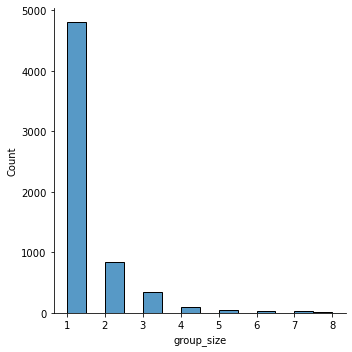

In [16]:
group_sizes = train.groupby(['group']).size().reset_index(name = "group_size")
display(group_sizes.head(3))
sns.displot(group_sizes, x='group_size')
plt.show()

In [17]:
df = group_sizes.groupby(['group_size']).size().reset_index(name='count')
df['%'] = ((df['count'] / df['count'].sum()) *100).round(2)
display(df)

,group_size,count,%
0,1,4805,77.29
1,2,841,13.53
2,3,340,5.47
3,4,103,1.66
4,5,53,0.85
5,6,29,0.47
6,7,33,0.53
7,8,13,0.21


In [18]:
# adding group_sizes column to the train dataset
train = pd.merge(train, group_sizes, on='group')

In [20]:
# adding group, no_in_group, and group_size to test dataset
test[['group', 'no_in_group']] = test['PassengerId'].str.split("_", expand = True)
group_sizes = test.groupby(['group']).size().reset_index(name = "group_size")
test = pd.merge(test, group_sizes, on='group')